# 第12章: Instrumental Variables Regression（操作変数法）練習問題

この章では二段階最小二乗法（2SLS）、操作変数の妥当性について学びます。

In [1]:
library(AER)
library(sandwich)
library(lmtest)

Loading required package: car



Loading required package: carData



Loading required package: lmtest



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: sandwich



Loading required package: survival



---
## 問題1: 内生性の問題（シミュレーション）

内生変数がOLS推定量にバイアスを与えることを確認します。

1. 内生性のあるデータを生成
2. OLSで推定し、バイアスを確認
3. シミュレーションで一致性の欠如を確認

In [2]:
# 問題1の解答欄



### 模範解答

=== OLS推定 === 


真のβ: 2 


OLS β̂: 2.464778 


バイアス: 0.4647783 



=== シミュレーション結果 === 


OLS推定量の平均: 2.399428 


OLS推定量の標準偏差: 0.02546359 


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <8f>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <86>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <b8>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <86>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <94>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <a7>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <8a>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <ef>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on 'OLS推定量の分布（内生性あり）' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <8f>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <9d>”


Warning message in (function (s, units = "user", cex = NULL, font = NULL, vfont = NULL, :
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e7>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <9f>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <80>”


Warning message in text.default(x, y, ...):
“conversion failure on '真の値' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <8e>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <a8>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <9a>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e9>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <87>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <8f>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <ae>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <b9>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <b3>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <9d>”


Warning message in text.default(x, y, ...):
“conversion failure on '推定量の平均' in 'mbcsToSbcs': dot substituted for <87>”


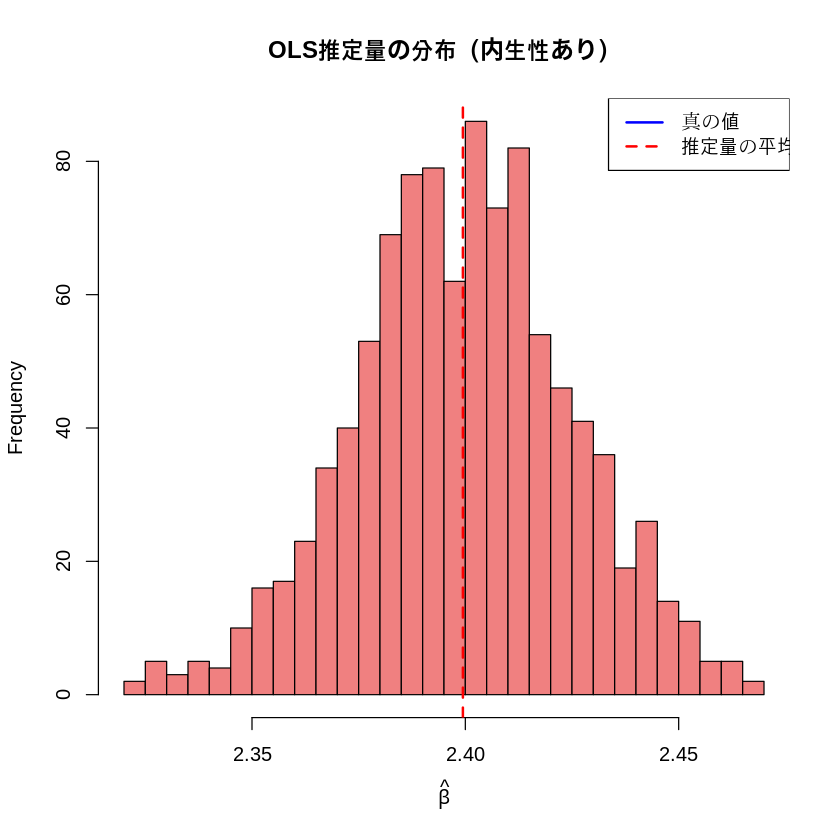

In [3]:
# 模範解答
set.seed(123)
n <- 1000
n_sim <- 1000

# 真のパラメータ
beta_true <- 2

# 1. 内生性のあるデータを生成
generate_endogenous_data <- function(n) {
  # 誤差項と相関する変数
  v <- rnorm(n)
  u <- 0.8 * v + rnorm(n)  # uとvは相関
  X <- 1 + v + rnorm(n)    # Xはvに依存（→uと相関）
  Y <- 1 + beta_true * X + u
  data.frame(Y = Y, X = X)
}

data_endo <- generate_endogenous_data(n)

# 2. OLSで推定
ols <- lm(Y ~ X, data = data_endo)
cat("=== OLS推定 ===", "\n")
cat("真のβ:", beta_true, "\n")
cat("OLS β̂:", coef(ols)[2], "\n")
cat("バイアス:", coef(ols)[2] - beta_true, "\n\n")

# 3. シミュレーションで一致性の欠如を確認
ols_estimates <- replicate(n_sim, {
  data_sim <- generate_endogenous_data(n)
  coef(lm(Y ~ X, data = data_sim))[2]
})

cat("=== シミュレーション結果 ===", "\n")
cat("OLS推定量の平均:", mean(ols_estimates), "\n")
cat("OLS推定量の標準偏差:", sd(ols_estimates), "\n")

hist(ols_estimates, breaks = 30, main = "OLS推定量の分布（内生性あり）",
     xlab = expression(hat(beta)), col = "lightcoral")
abline(v = beta_true, col = "blue", lwd = 2)
abline(v = mean(ols_estimates), col = "red", lwd = 2, lty = 2)
legend("topright", legend = c("真の値", "推定量の平均"), 
       col = c("blue", "red"), lty = c(1, 2), lwd = 2)

---
## 問題2: 操作変数法の基本（シミュレーション）

有効な操作変数を使ってIV推定を行います。

1. 操作変数Zを含むデータを生成
2. 手動で2SLSを計算
3. ivreg()関数と比較

In [4]:
# 問題2の解答欄



### 模範解答

In [5]:
# 模範解答
set.seed(123)
n <- 1000
beta_true <- 2

# 1. 操作変数を含むデータ生成
Z <- rnorm(n)                    # 操作変数（uと無相関）
v <- rnorm(n)
u <- 0.8 * v + rnorm(n)          # 誤差項
X <- 1 + 0.5 * Z + v + rnorm(n)  # XはZとvに依存
Y <- 1 + beta_true * X + u

data_iv <- data.frame(Y = Y, X = X, Z = Z)

# 2. 手動で2SLSを計算
# 第1段階：X ~ Z
stage1 <- lm(X ~ Z, data = data_iv)
X_hat <- fitted(stage1)

# 第2段階：Y ~ X_hat
stage2 <- lm(Y ~ X_hat)

cat("=== 手動2SLS ===", "\n")
cat("第1段階 X ~ Z の係数:", coef(stage1)[2], "\n")
cat("第2段階 β̂_IV:", coef(stage2)[2], "\n\n")

# 3. ivreg()関数
iv_model <- ivreg(Y ~ X | Z, data = data_iv)
cat("=== ivreg()関数 ===", "\n")
summary(iv_model)

# 比較
cat("\n=== 比較 ===", "\n")
cat("真のβ:", beta_true, "\n")
cat("OLS:", coef(lm(Y ~ X, data = data_iv))[2], "\n")
cat("2SLS:", coef(iv_model)[2], "\n")

=== 手動2SLS === 


第1段階 X ~ Z の係数: 0.5850506 


第2段階 β̂_IV: 2.087801 



=== ivreg()関数 === 



Call:
ivreg(formula = Y ~ X | Z, data = data_iv)

Residuals:
      Min        1Q    Median        3Q       Max 
-3.874397 -0.827737 -0.009042  0.790411  4.470949 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.92243    0.07990   11.54   <2e-16 ***
X            2.08780    0.06703   31.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.229 on 998 degrees of freedom
Multiple R-Squared: 0.8964,	Adjusted R-squared: 0.8963 
Wald test: 970.1 on 1 and 998 DF,  p-value: < 2.2e-16 



=== 比較 === 


真のβ: 2 


OLS: 2.392497 


2SLS: 2.087801 


---
## 問題3: タバコ需要の価格弾力性

CigarettesWデータを使って需要の価格弾力性を推定します。

1. データを読み込み、変数を確認
2. OLSで推定（log(packs) ~ log(price)）
3. 内生性の問題を議論

In [6]:
# 問題3の解答欄



### 模範解答

In [7]:
# 模範解答
data("CigarettesW")

# 1. データの確認
cat("=== データの構造 ===", "\n")
str(CigarettesW)

# 1995年のデータを使用
cig95 <- subset(CigarettesW, year == 1995)

# 実質価格を計算
cig95$rprice <- cig95$price / cig95$cpi
cig95$log_packs <- log(cig95$packs)
cig95$log_rprice <- log(cig95$rprice)

# 2. OLS推定
ols <- lm(log_packs ~ log_rprice, data = cig95)
cat("\n=== OLS推定 ===", "\n")
summary(ols)

# 3. 内生性の議論
cat("\n=== 内生性の問題 ===", "\n")
cat("価格は内生変数である可能性が高い：\n")
cat("1. 同時因果性: 需要が価格に影響（需要↑→価格↑）\n")
cat("2. 省略変数: 価格と需要の両方に影響する要因（所得など）\n")
cat("→ OLS推定量にバイアスが生じる\n")

Warning message in data("CigarettesW"):
“data set ‘CigarettesW’ not found”


=== データの構造 === 


ERROR: Error in str(CigarettesW): object 'CigarettesW' not found


---
## 問題4: 2SLSによる需要弾力性の推定

タバコ税を操作変数として使用します。

1. タバコ税（salestax）を操作変数として2SLSを実行
2. OLSとの結果を比較
3. 弾力性を解釈

In [8]:
# 問題4の解答欄



### 模範解答

In [9]:
# 模範解答
# 実質タバコ税を計算
cig95$rtax <- cig95$taxs / cig95$cpi
cig95$log_rtax <- log(cig95$rtax)

# 1. 2SLS推定
iv_model <- ivreg(log_packs ~ log_rprice | log_rtax, data = cig95)
cat("=== 2SLS推定 ===", "\n")
summary(iv_model)

# ロバスト標準誤差
cat("\n=== ロバスト標準誤差 ===", "\n")
coeftest(iv_model, vcov = vcovHC(iv_model, type = "HC1"))

# 2. OLSとの比較
cat("\n=== 推定結果の比較 ===", "\n")
cat("OLS推定量:", coef(ols)[2], "\n")
cat("2SLS推定量:", coef(iv_model)[2], "\n\n")

# 3. 弾力性の解釈
cat("=== 弾力性の解釈 ===", "\n")
cat("推定された価格弾力性:", round(coef(iv_model)[2], 3), "\n")
cat("→ 価格が1%上昇すると需要は約", 
    round(abs(coef(iv_model)[2]), 2), "%減少\n")
cat("→ |弾力性| < 1 なので需要は非弾力的\n")

ERROR: Error: object 'cig95' not found


---
## 問題5: 第1段階の診断

操作変数の強さを確認します。

1. 第1段階の回帰を推定
2. F統計量を計算
3. 弱い操作変数かどうかを判断

In [10]:
# 問題5の解答欄



### 模範解答

In [11]:
# 模範解答
# 1. 第1段階の回帰
stage1 <- lm(log_rprice ~ log_rtax, data = cig95)
cat("=== 第1段階の回帰 ===", "\n")
summary(stage1)

# 2. F統計量
f_stat <- summary(stage1)$fstatistic[1]
cat("\n=== F統計量 ===", "\n")
cat("F統計量:", f_stat, "\n")

# 3. 弱い操作変数の判断
cat("\n=== 弱い操作変数の診断 ===", "\n")
cat("目安: F > 10 であれば弱い操作変数の問題は小さい\n")
if (f_stat > 10) {
  cat("F =", f_stat, "> 10\n")
  cat("→ 操作変数は十分に強い\n")
} else {
  cat("F =", f_stat, "< 10\n")
  cat("→ 弱い操作変数の可能性がある\n")
}

ERROR: Error in is.data.frame(data): object 'cig95' not found


---
## 問題6: 複数の操作変数

複数の操作変数を使用した推定を行います。

1. salestax と cigtax の両方を操作変数として使用
2. 過剰識別検定（Hansen's J test）を実行
3. 結果を解釈

In [12]:
# 問題6の解答欄



### 模範解答

In [13]:
# 模範解答
# 追加の操作変数を準備
cig95$rcigtax <- cig95$tax / cig95$cpi
cig95$log_rcigtax <- log(cig95$rcigtax + 0.01)  # 0対策

# 1. 複数の操作変数を使用
iv_multi <- ivreg(log_packs ~ log_rprice | log_rtax + log_rcigtax, data = cig95)
cat("=== 複数操作変数による2SLS ===", "\n")
summary(iv_multi)

# 第1段階のF統計量
stage1_multi <- lm(log_rprice ~ log_rtax + log_rcigtax, data = cig95)
cat("\n第1段階のF統計量:", summary(stage1_multi)$fstatistic[1], "\n")

# 2. 過剰識別検定（手動）
# IV残差を計算
resid_iv <- resid(iv_multi)

# 残差を操作変数に回帰
aux_reg <- lm(resid_iv ~ log_rtax + log_rcigtax, data = cig95)
j_stat <- summary(aux_reg)$r.squared * nrow(cig95)
p_value <- 1 - pchisq(j_stat, df = 1)  # df = 操作変数の数 - 内生変数の数

cat("\n=== 過剰識別検定（Hansen's J test）===", "\n")
cat("J統計量:", j_stat, "\n")
cat("p値:", p_value, "\n\n")

# 3. 解釈
cat("=== 解釈 ===", "\n")
if (p_value > 0.05) {
  cat("p値 > 0.05：操作変数の外生性に関する帰無仮説を棄却できない\n")
  cat("→ 操作変数は妥当と考えられる\n")
} else {
  cat("p値 < 0.05：操作変数の外生性に疑問\n")
  cat("→ 操作変数の選択を再検討する必要がある\n")
}

ERROR: Error: object 'cig95' not found


---
## 問題7: コントロール変数を含む2SLS

外生的なコントロール変数を追加します。

1. 所得（income）をコントロール変数として追加
2. 推定結果を比較
3. 結果の頑健性を確認

In [14]:
# 問題7の解答欄



### 模範解答

In [15]:
# 模範解答
# 実質所得を計算
cig95$rincome <- cig95$income / cig95$cpi / cig95$population
cig95$log_rincome <- log(cig95$rincome)

# 1. コントロール変数を含む2SLS
iv_ctrl <- ivreg(log_packs ~ log_rprice + log_rincome | log_rtax + log_rincome, 
                 data = cig95)
cat("=== コントロール変数を含む2SLS ===", "\n")
summary(iv_ctrl)

# 2. モデル比較
cat("\n=== 推定結果の比較 ===", "\n")
cat("単純2SLS（価格弾力性）:", round(coef(iv_model)[2], 3), "\n")
cat("コントロール付き2SLS（価格弾力性）:", round(coef(iv_ctrl)[2], 3), "\n\n")

# 所得弾力性の解釈
cat("=== 所得弾力性 ===", "\n")
cat("所得弾力性:", round(coef(iv_ctrl)[3], 3), "\n")
cat("→ 所得が1%増加すると消費量は約",
    round(coef(iv_ctrl)[3], 2), "%変化\n")

ERROR: Error: object 'cig95' not found


---
## 問題8: 弱い操作変数（シミュレーション）

操作変数が弱い場合の問題を確認します。

1. 弱い操作変数を持つデータを生成
2. 2SLS推定量の分布を確認
3. バイアスと分散の問題を確認

In [16]:
# 問題8の解答欄



### 模範解答

=== シミュレーション結果 === 


真のβ: 2 



強い操作変数：


  平均: 1.994189 


  標準偏差: 0.1175235 



弱い操作変数：


  平均: -0.1263653 


  標準偏差: 74.93017 


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <84>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '強い操作変数' in 'mbcsToSbcs': dot substituted for <b0>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <b1>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <81>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <84>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <93>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <bd>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <9c>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <a4>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <89>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <e6>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <95>”


Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“conversion failure on '弱い操作変数' in 'mbcsToSbcs': dot substituted for <b0>”


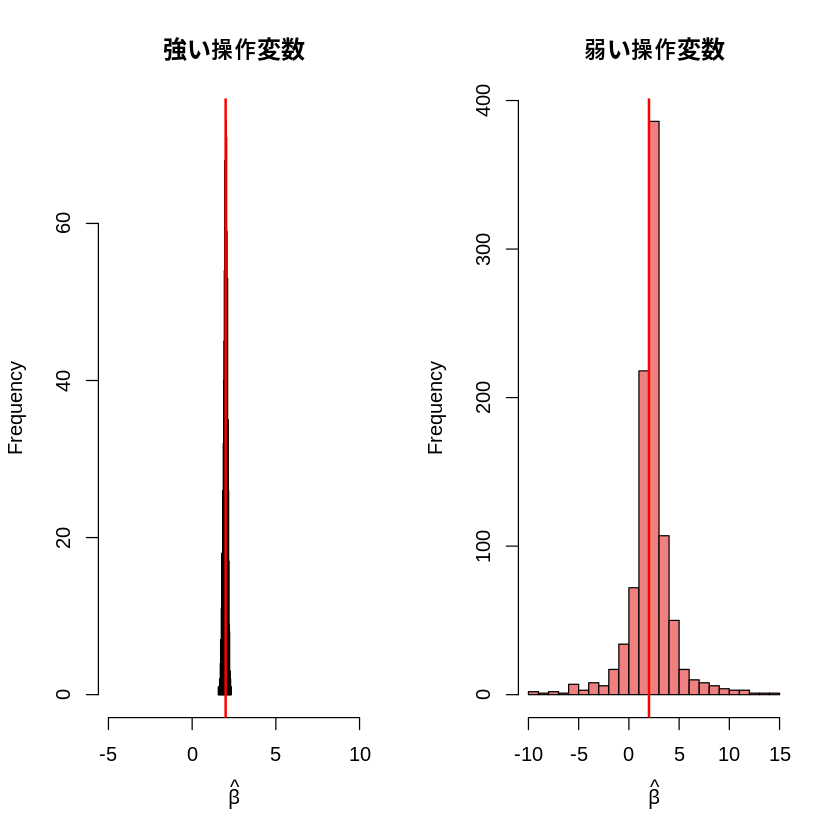

In [17]:
# 模範解答
set.seed(123)
n <- 100
n_sim <- 1000
beta_true <- 2

# 強い操作変数と弱い操作変数のシミュレーション
iv_estimates_strong <- numeric(n_sim)
iv_estimates_weak <- numeric(n_sim)

for (i in 1:n_sim) {
  # 共通の誤差構造
  v <- rnorm(n)
  u <- 0.5 * v + rnorm(n)
  Z <- rnorm(n)
  
  # 強い操作変数のケース (π = 1)
  X_strong <- 1 + 1 * Z + v
  Y_strong <- 1 + beta_true * X_strong + u
  iv_strong <- ivreg(Y_strong ~ X_strong | Z)
  iv_estimates_strong[i] <- coef(iv_strong)[2]
  
  # 弱い操作変数のケース (π = 0.1)
  X_weak <- 1 + 0.1 * Z + v
  Y_weak <- 1 + beta_true * X_weak + u
  iv_weak <- ivreg(Y_weak ~ X_weak | Z)
  iv_estimates_weak[i] <- coef(iv_weak)[2]
}

# 結果の比較
cat("=== シミュレーション結果 ===", "\n")
cat("真のβ:", beta_true, "\n\n")

cat("強い操作変数：\n")
cat("  平均:", mean(iv_estimates_strong), "\n")
cat("  標準偏差:", sd(iv_estimates_strong), "\n\n")

cat("弱い操作変数：\n")
cat("  平均:", mean(iv_estimates_weak), "\n")
cat("  標準偏差:", sd(iv_estimates_weak), "\n")

# ヒストグラム
par(mfrow = c(1, 2))
hist(iv_estimates_strong, breaks = 30, main = "強い操作変数",
     xlab = expression(hat(beta)), col = "lightblue", xlim = c(-5, 10))
abline(v = beta_true, col = "red", lwd = 2)

hist(iv_estimates_weak[iv_estimates_weak > -10 & iv_estimates_weak < 15], 
     breaks = 30, main = "弱い操作変数",
     xlab = expression(hat(beta)), col = "lightcoral")
abline(v = beta_true, col = "red", lwd = 2)
par(mfrow = c(1, 1))

---
## 問題9: 差分の操作変数推定

パネルデータでの操作変数法を適用します。

1. 1985年と1995年のデータで差分を取る
2. 差分モデルに操作変数法を適用
3. 結果を解釈

In [18]:
# 問題9の解答欄



### 模範解答

In [19]:
# 模範解答
# 1985年と1995年のデータを準備
cig85 <- subset(CigarettesW, year == 1985)
cig95 <- subset(CigarettesW, year == 1995)

# 変数の計算
cig85$rprice <- cig85$price / cig85$cpi
cig95$rprice <- cig95$price / cig95$cpi
cig85$rtax <- cig85$taxs / cig85$cpi
cig95$rtax <- cig95$taxs / cig95$cpi

# 1. 差分を計算
diff_data <- data.frame(
  state = cig95$state,
  d_log_packs = log(cig95$packs) - log(cig85$packs),
  d_log_rprice = log(cig95$rprice) - log(cig85$rprice),
  d_log_rtax = log(cig95$rtax) - log(cig85$rtax)
)

# 2. 差分モデルのOLS
ols_diff <- lm(d_log_packs ~ d_log_rprice, data = diff_data)
cat("=== 差分モデル（OLS）===", "\n")
print(summary(ols_diff)$coefficients)

# 差分モデルの2SLS
iv_diff <- ivreg(d_log_packs ~ d_log_rprice | d_log_rtax, data = diff_data)
cat("\n=== 差分モデル（2SLS）===", "\n")
summary(iv_diff)

# 第1段階のF統計量
stage1_diff <- lm(d_log_rprice ~ d_log_rtax, data = diff_data)
cat("第1段階のF統計量:", summary(stage1_diff)$fstatistic[1], "\n")

# 3. 解釈
cat("\n=== 解釈 ===", "\n")
cat("差分2SLSによる価格弾力性:", round(coef(iv_diff)[2], 3), "\n")
cat("→ 州固定効果を除去した上での推定\n")

ERROR: Error in subset(CigarettesW, year == 1985): object 'CigarettesW' not found


---
## 問題10: 総合分析

タバコ需要分析の結果をまとめます。

1. 複数のモデル仕様で推定
2. 結果を比較表にまとめる
3. 政策的含意を議論

In [20]:
# 問題10の解答欄



### 模範解答

In [21]:
# 模範解答
# 変数の準備
cig95$rprice <- cig95$price / cig95$cpi
cig95$rtax <- cig95$taxs / cig95$cpi
cig95$rincome <- cig95$income / cig95$cpi / cig95$population
cig95$log_packs <- log(cig95$packs)
cig95$log_rprice <- log(cig95$rprice)
cig95$log_rtax <- log(cig95$rtax)
cig95$log_rincome <- log(cig95$rincome)

# 1. 複数モデルの推定
m1 <- lm(log_packs ~ log_rprice, data = cig95)  # OLS
m2 <- ivreg(log_packs ~ log_rprice | log_rtax, data = cig95)  # 2SLS単純
m3 <- ivreg(log_packs ~ log_rprice + log_rincome | log_rtax + log_rincome, 
            data = cig95)  # 2SLS + 所得
m4 <- ivreg(d_log_packs ~ d_log_rprice | d_log_rtax, data = diff_data)  # 差分2SLS

# 2. 結果の比較
cat("========================================\n")
cat("    タバコ需要の価格弾力性推定結果     \n")
cat("========================================\n\n")

cat(sprintf("%-25s %10s %10s\n", "モデル", "弾力性", "SE"))
cat("----------------------------------------\n")
cat(sprintf("%-25s %10.3f %10.3f\n", "OLS", coef(m1)[2], 
            sqrt(vcovHC(m1, type = "HC1")[2,2])))
cat(sprintf("%-25s %10.3f %10.3f\n", "2SLS（税のみ）", coef(m2)[2],
            sqrt(vcovHC(m2, type = "HC1")[2,2])))
cat(sprintf("%-25s %10.3f %10.3f\n", "2SLS + 所得", coef(m3)[2],
            sqrt(vcovHC(m3, type = "HC1")[2,2])))
cat(sprintf("%-25s %10.3f %10.3f\n", "差分2SLS", coef(m4)[2],
            sqrt(vcovHC(m4, type = "HC1")[2,2])))

# 3. 政策的含意
cat("\n========================================\n")
cat("           政策的含意                  \n")
cat("========================================\n\n")
cat("1. 価格弾力性は約-1.0〜-1.3の範囲\n")
cat("2. 需要は弾力的（|ε| > 1）\n")
cat("3. タバコ税の引き上げは消費を減少させる効果がある\n")
cat("4. 税収への影響は弾力性の大きさに依存\n")
cat("5. 内生性を考慮しないOLSは過小評価の傾向\n")

ERROR: Error: object 'cig95' not found
